Necessary imports:

In [25]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from utils import gaussian_density,gaussian_density_optim
from utils import read_data_from_txt

The ML estimator for the mean is $\mu=\frac{1}{N}\sum_{i=1}^{N}x_i $. It's always unbiased, as $ \mathbb{E} [\overline{x}]=\mathbb{E}[\frac{1}{N}\sum_{i=1}^{N}x_i]=\frac{1}{N}\mathbb{E}[\sum_{i=1}^{N}x_i]=\frac{1}{N}N \mathbb{E}[x]=\mu$

In [26]:
def compute_mle_mu(X:np.ndarray):
    '''
    computing the mean across each dimension

    :param X: multidimensional data as numpy-matrix
    :return: array of the means across each dimension
    '''
    # mean across each dimension
    mu=X.mean(axis=0)

    return mu

The biased ML estimator for the covariance is $ \Sigma=\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})(x_i - \overline{x})^T $, while the unbiased ML estimator is $ \Sigma=\frac{1}{N-1}\sum_{i=1}^{N}(x_i - \overline{x})(x_i - \overline{x})^T $

In [27]:
def compute_mle_sigma(X:np.ndarray, biased=False):
    '''
    computing the MLE for the covariance

    :param X: multidimensional data as numpy-matrix
    :param biased: Whether to use unbiased function or not
    :return: numpy matrix with MLE for the covariance
    '''
    # mean across each dimension
    mu=X.mean(axis=0)

    # number of data points
    N=X.shape[0]

    # number of dimensions
    cols=X.shape[1]

    # initiate covariance matrix with zeros of size (dim,dim)
    mle_sigma=np.zeros([cols,cols])

    if biased:
        # computing biased MLE for sigma
        for x in range(cols):
            for y in range(cols):
                mle_sigma[x][y]=1/N*np.sum((np.stack(X,1)[x]-mu[x])*(np.stack(X,1)[y]-mu[y]).T,axis=0)
    else:
        # computing unbiased MLE for sigma
        for x in range(cols):
            for y in range(cols):
                mle_sigma[x][y]=1/(N-1)  *np.sum((np.stack(X,1)[x]-mu[x])*(np.stack(X,1)[y]-mu[y]).T,axis=0)

    return mle_sigma


The log-likelihood is $ \ln{\mathcal{N}(\bf{x};\mu,\bf{\Sigma})}=-\frac{D}{2}\ln{(2\pi)}-\frac{1}{2}\ln{(\det \bf{\Sigma})}-\frac{1}{2}(\textbf{x}-\mu)^T \bf{\Sigma^{-1}}(\bf{x}-\mu)$. The constant $\frac{D}{2}\ln{(2\pi)}$ can be omitted.

In [28]:
def compute_log_likelihood(x,sigma,mu):
    '''
    slower version of log-likelihood where the indepence of each variable/dimension is not assumed

    :param x: single data point
    :param sigma: covariance matrix
    :param mu: mean across each dimension
    :return: single value with log-likelihood
    '''
    # number of dimensions
    d=sigma.shape[0]

    # defining last part of the equation
    eq1=np.dot((x - mu).T,np.linalg.inv(sigma))
    eq=np.dot(eq1,(x-mu))

    return -np.log((2*np.pi)**(d/2))-np.log(np.sqrt(np.linalg.det(sigma))) - 0.5 * eq

This equation for log-likelihood can be simplfied to make the computation more efficient by applying the independency assumption between the variables in Naive Bayes: $\ln{\mathcal{N}(\bf{x};\mu,\bf{\Sigma})}=-\ln{(\frac{1}{(2\pi)^{\frac{D}{2}}\prod_{i=1}^D\sigma_{i}})} -\frac{1}{2}\sum_{i=1}^D(\frac{x_i - \mu_i}{\sigma_i})^2$. Again, the constant $\frac{1}{(2\pi)^{\frac{D}{2}}$ can be omitted.

In [29]:
def compute_log_likelihood_optim(X, sigma, mu):
    '''
    optimized version of log-likelihood where the indepence of each variable/dimension is assumed

    :param X: numpy matrix containing all data points
    :param sigma: covariance matrix
    :param mu: mean across each dimension
    :return: numpy array with log-likelihood for each data point in X
    '''
    # number of dimensions
    d=sigma.shape[0]

    # defining last part of the equation
    eq=np.sum((X - mu) ** 2 / np.diag(sigma), axis=1)

    return -np.log((2*np.pi)**(d/2)*np.prod(np.sqrt(np.diag(sigma)))) - 0.5 * eq

The prior of a class is computed simply by counting the number of data points $N_{j}$ belonging to class $j$ divided by the total number of data points $N$: $prior_{j}=\frac{N_{j}}{N}$

In [30]:
def compute_prior(Y):
    '''
    Computing the prior for each class

    :param Y: computing the labels by counting the number of data points for each class
            and dividing it by the sum of all data points
    :return: numpy array with priors for each class
    '''
    classes,counts=np.unique(Y,return_counts=True)
    prior=np.array([x/len(Y) for x in counts])
    return prior

Defining paths of the data and reading it:

In [31]:
def read_data_from_txt(path,dim):
    '''
    reading data of indicated dimension
    
    :param path: path to txt-file
    :param dim: dimension of the matrix in the txt-file
    :return: numpy array containing all data points
    '''
    with open(path, "r") as f:
        data= f.read()

    return np.array(data.split(),dtype=np.float32).reshape(dim)


path_c1="data/part1/densEst1.txt"
path_c2="data/part1/densEst2.txt"
data_c1=read_data_from_txt(path_c1,dim=(-1,2))
data_c2=read_data_from_txt(path_c2,dim=(-1,2))

Now we have to compute the MLE for $\Sigma$ and $\mu$, setting up the array for the 2-dimensional data and the 1-dimensional labels and computing the prior:

In [32]:
sigma=[]
mu=[]

# compute params for class 1
sigma.append(compute_mle_sigma(data_c1,biased=False))
mu.append(compute_mle_mu(data_c1))

# compute params for class 2
sigma.append(compute_mle_sigma(data_c2,biased=False))
mu.append(compute_mle_mu(data_c2))

# computing the labels: data in data_c1 belongs to class 1 and data in data_c2 to class 2
Y=np.append(np.zeros([len(data_c1)]),(np.ones([len(data_c2)])))

# stack data points of both class
X=np.vstack([data_c1,data_c2])

# computing the prior for both classes
prior=compute_prior(Y)

The probability density function (pdf) for multivariate gaussian distribution is $p(x;\mu,\Sigma)=\frac{1}{(2\pi)^\frac{d}{2}\det\Sigma^\frac{1}{2}} e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}$:

In [33]:
def gaussian_density(x, mu, sigma):
    '''
    computing the gaussian probability of the passed data point x

    :param x: single data point
    :param mu: mean across each dimension
    :param sigma: covariance matrix
    :return: probability of the passed data point x
    '''
    # dimension of x
    d =sigma.shape[0]

    # defining last part of the equation
    eq1 = np.dot((x - mu).T, np.linalg.inv(sigma))
    eq = np.dot(eq1, (x - mu))

    p = 1 / ((2 * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(sigma))) * np.exp(-0.5 * eq)
    if np.isnan(p) or np.isinf(p):
        print("p is nan")
    return p


The equation of the pdf for multivariate gaussian distribution shown before is expensive and can be simplified by utilizing the assumption of naive bayes, that the variables are independent to each other. That means, that we can just use the diagonal values of the covariance matrix $\Sigma$, which are equivilant to the variances of the first variable $\sigma_{11}$ and second variable $\sigma_{22}$. So $\det\Sigma=\big(\begin{smallmatrix}
\sigma_{11} & \sigma_{12}\\
\sigma_{21} & \sigma_{22}
\end{smallmatrix}\big)=\sigma_{11}\sigma_{22}$, as $\sigma_{12}$ and $\sigma_{21}$ are assumed to be 0.

The equation we obtain after simplifying the former one is: $p(x;\mu,\Sigma)= \frac{1}{\sqrt{2\pi}\prod_i^d \sigma_{i}}e^{-\frac{1}{2}\sum_i^d\frac{(x_i-\mu_i)^2}{\sigma_i^2}}$ where $d$ is the dimension. The implementation looks like this:


In [34]:
def gaussian_density_optim(X, mu, sigma):
    '''
    optimized equation of the function gaussian_density(.) by making use of the independendy assumption of Naive Bayes

    :param X: batch of data points
    :param mu: mean across each dimension
    :param sigma: covariance matrix
    :return: numpy array of the probabilities of each data point in the batch X
    '''

    # dimension of x
    d = sigma.shape[0]

    # defining last part of the equation
    eq=np.exp(-0.5 * np.sum((X - mu) ** 2 / np.diag(sigma), axis=1))

    p = 1 / ((2 * np.pi) ** (d / 2) * np.prod(np.sqrt(np.diag(sigma)))) *eq

    return p

Here we plot the contour of the data points. The decision border can be computed by subtracting the posterior of class 1 from that of class 2: $g=g_{1}-g_{2}$, where $g_{1}$ is the classifier/posterior of class 1 and of class 2. If the difference is positive and we have equal costs for both classes, then class 1 is predicted, otherwise class 2.

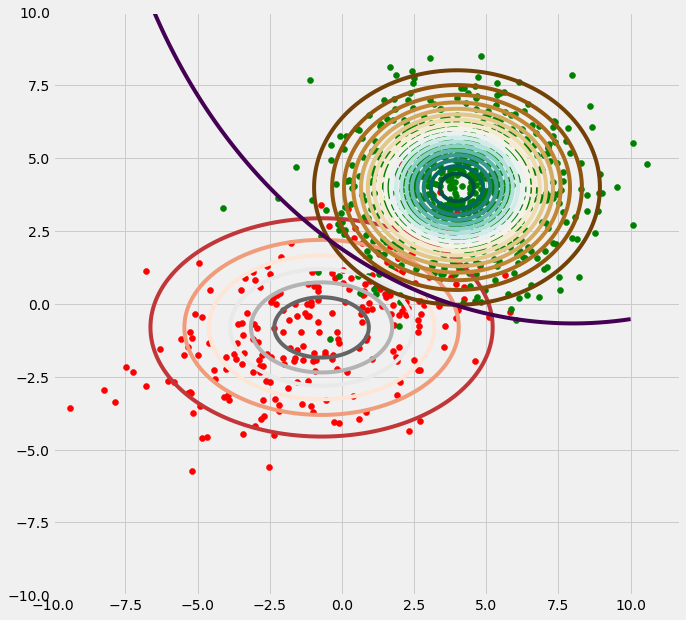

In [45]:
def plot_contour(sigma,mu,prior):
    '''
    Plotting the contour and the decision boundary of both classes

    :param sigma: covariance matrix
    :param mu: array with mean of each dimension
    :param prior: array with the prior of each class
    :return:
    '''

    # log-posterior/classifier
    def g(x, y,idx_class):
        probs=np.log(prior[idx_class])+compute_log_likelihood_optim(X=np.column_stack((x, y)), mu=mu[idx_class], sigma=sigma[idx_class])
        return np.array(probs)

    x = np.linspace(-10, 10, 500)
    y = np.linspace(-10, 10, 500)
    X, Y = np.meshgrid(x, y)

    pos = np.array([X.flatten(), Y.flatten()]).T

    rv3=np.array(gaussian_density_optim(pos, mu[0], sigma[0]))
    rv4=np.array(gaussian_density_optim(pos, mu[1], sigma[1]))

    fig = plt.figure(figsize=(10, 10))
    ax0 = fig.add_subplot(111)

    ax0.contour(X, Y, rv3.reshape(500, 500), cmap='RdGy')
    ax0.contour(X, Y, rv4.reshape(500, 500), 20, cmap='BrBG')
    x=X.flatten()
    y=Y.flatten()
    p = (g(x, y, idx_class=0) - g(x, y, idx_class=1)).reshape(X.shape)

    #scatter class 1
    ax0.scatter(data_c1[:,0], data_c1[:, 1],c="red")
    # scatter class 2
    ax0.scatter(data_c2[:, 0], data_c2[:, 1],c="green")

    ax0.contour(X, Y, p, levels=[0])

    plt.show()

    
plot_contour(sigma,mu,prior)



Plotting the surface for class 1:

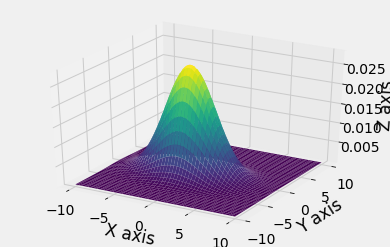

In [40]:
def plot_surface(sigma,mu):
    '''
    plotting 3D surface of the gaussian distributions with the passed parameter

    :param sigma: covariance matrix
    :param mu: array with mean of each dimension
    :return:
    '''
    # Creating 2-dim meshgrid for pos -10 to 10 with 500 steps for each dim
    steps=500
    x = np.linspace(-10, 10, steps)
    y = np.linspace(-10, 10, steps)
    X, Y = np.meshgrid(x, y)

    # init meshgrid with dim (500,500,2) to create pairs of each possible position in the 2-dim grid
    grid = np.empty(X.shape + (2,))

    # assign the positions for X at first pair position
    grid[:, :, 0] = X
    # assign the positions for X at second pair position
    grid[:, :, 1] = Y

    # compute gaussian probabilities for a 3D environment: 500x500x2 dimension
    pdf = np.array([gaussian_density_optim(grid[i],mu=mu,sigma=sigma) for i in range(grid.shape[0])])

    # draw the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, pdf, cmap='viridis', linewidth=0)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()
    
plot_surface(sigma[0],mu[0])



Plotting the surface for class 2:

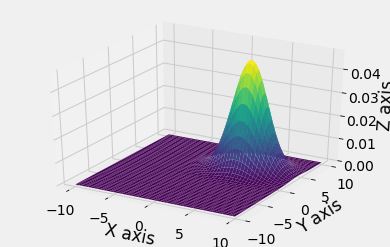

In [41]:
plot_surface(sigma[1],mu[1])

Run predictions and compute the accuracy:

In [44]:
def predict(X,prior,mu, sigma):
    '''

    :param X: numpy matrix with all data points
    :param prior: numpy array with the prior value of each class
    :param mu: means for each class of each dimension
    :param sigma: covariance matrix for each class
    :return: numpy array with values 0 (class 1) or 1 (class 2) for each data point
    '''
    # computing the log-posterior, which is the probability that it belongs to each class
    probs=[np.log(prior[c])+compute_log_likelihood_optim(X,sigma=sigma[c],mu=mu[c]) for c in range(len(prior))]

    # select class with highest probability
    y=np.argmax(probs,axis=0)
    return y


y_pred = predict(X, prior, mu, sigma)
print("Accuracy:",np.mean(Y==y_pred)*100, "%")

Accuracy: 94.6 %
